点郡データから標高ラスターを生成。パラメータ調整可能。（必要手続き：Driveの接続）

広域の初動の場合、初めて設定したmindepthを実行すると３０分ほどかかります。

ステップ２の再実行後はflag_renewをTrueにしてください。

全て実行した後、maxdepthを変更して外れ値処理以下を１度再実行できるぐらいのリソース有余です。２度目の再実行あたりでRAM不足でクラッシュしますので、RAMが少なそうならば再起動で実行してください。

In [ ]:
# @title Googleドライブの準備
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [54]:
# @title パラメータの設定
casename = "kurume-r2" #"omuta-r2" #"kurume-r2"

mindepth = 0.05 # assume minimal depth of water to be detected
maxdem = 300 # maximum dem assumed for water surface. set something unrealy high.

maxdepth = 4 # 4.27 #4 # m
maxarea = 600000 # in the unit of pixels or 25 m^2

flag_cache = False #True # Set False if you do not want a cache file from the previous time.
flg_display = False

In [55]:
# @title 詳細設定用パラメータ（基本的には操作不要）

enable_savefig = False # 図をGoogleドライブに保存する？

zoomlevel = 15 # DEM zoom level to fetch
wall_height = 1000

analysis_tilesize = 4

errordem = -1000

# デバッグ用出力
global globalflag_debug

# 保存先
path_home = "/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/"
path_dem = path_home + "/DEM/"
path_case = path_home + casename + "/"
file_flbbox = path_case + "floodprb_bbox.npy"
file_pts = path_case + "flood_points.pkl"
file_dem_fmt = path_case + "dem_{}_{}-{}_{}-{}.npz"
file_savepts = path_case + "save_pts.npy"

file_pts_mindepth = path_case + "flood_points_min{0:04d}.pkl"

file_flooddem = path_case + "flood_dem_{0:04d}.npz"
file_flooddepth = path_case + "flood_depth_{0:04d}.npz"

# 標高データの基本パラメータ
demtile_len = 256

In [56]:
# @title 主要ライブラリインポート
!pip install numpy==1.26.0
#!pip install scipy==1.11.3
!pip install scikit-image==0.22.0
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
import requests
import os
#import cv2
from scipy import ndimage as ndi
from progressbar import progressbar
#from sklearn.ensemble import IsolationForest
from shapely import box
import sys
sys.path.append(path_home)
import plateau_floodsar_lib as pfsl

In [57]:
# @title 領域の読み込み
boundbox = np.load(file_flbbox)
print(boundbox)

[130.40000697  33.22445068 130.59998291  33.34999988]


## 国土地理院の標高データの取得

In [58]:
# @title DEMマップ取得
print(boundbox)
bbox = box(*boundbox)
print(bbox)
gdm = pfsl.GiajDemManager(path_home,dem_types = [{"type":"dem5a","z":15},{"type":"dem5b","z":15}])
gdm.load_dem_tiles(bbox)
tile = gdm.produce_tile_stiched()
lons = tile["lons"]
lats = tile["lats"]
demmap = tile["dem"]

[130.40000697  33.22445068 130.59998291  33.34999988]
POLYGON ((130.5999829054351 33.224450683790295, 130.5999829054351 33.349999879860974, 130.4000069710961 33.349999879860974, 130.4000069710961 33.224450683790295, 130.5999829054351 33.224450683790295))


100% (19 of 19) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [59]:
print("dem range = ", np.nanmin(demmap), np.nanmax(demmap))

dem range =  -3.2 437.88


## 標高に基づいた浸水域の拡大

In [60]:
scale = np.concatenate([np.arange(3,10,1),np.arange(10,maxdem+30,30)])
print(scale)

[  3   4   5   6   7   8   9  10  40  70 100 130 160 190 220 250 280 310]


In [61]:
vbi = pfsl.ValueBoundInspector(gdm, scale=scale)#, method=lambda data,x:data>=x)
vbi.set_cntrs_all()


  0% (0 of 18) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Preparing all contours


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


In [62]:
#@title 点郡の読み込み＆DEM情報付与
pts_filepath = file_pts_mindepth.format(int(mindepth*100))
if flag_cache and os.path.isfile(pts_filepath):
  print(f"Loading the previous result from {pts_filepath}")
  with open(file_pts, "rb") as ifile:
    flood_pts = pickle.load(ifile)
else:
  with open(file_pts, "rb") as ifile:
    flood_pts = pickle.load(ifile)
  for pt in progressbar(flood_pts):
    if "dem" not in pt:
      try:
        pt["dem"] = gdm.calc_dem_interp(pt["lon"],pt["lat"])+mindepth
      except IndexError:
        pt["dem"] = np.nan
  flood_pts = [pt for pt in flood_pts if pt["dem"] <= maxdem]
  for pt in progressbar(flood_pts):
    if "area" not in pt:
      pt["area"] = vbi.calc_area_bound(pt["lon"],pt["lat"],pt["dem"])
    if "mindem" not in pt:
      pt["mindem"] = vbi.get_mindem_bound(pt["lon"],pt["lat"],pt["dem"])
    if "maxdepth" not in pt:
      pt["maxdepth"] = pt["dem"] - pt["mindem"]
    #print(pt)
  vbi.release_cntrs_all()
  with open(pts_filepath, "wb") as ofile:
    pickle.dump(flood_pts, ofile)
  print(f"The points are saved to {pts_filepath} for future runs.")
print(len(flood_pts))
print(flood_pts[0:3])
print(demmap.shape)
print(lats.shape)
print(lons.shape)

100% (1745177 of 1745177) |##############| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (0 of 1578801) |                    | Elapsed Time: 0:00:00 ETA:  --:--:--/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/plateau_floodsar_lib.py:674: RuntimeWarning: All-NaN axis encountered
  return np.nanmin([mdl,mdh])
100% (1578801 of 1578801) |##############| Elapsed Time: 0:06:45 Time:  0:06:45


The points are saved to /content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/kurume-r2/flood_points_min0005.pkl for future runs.
1578801
[{'lon': 130.40010609039862, 'lat': 33.271971741664814, 'dem': 3.3985027189641475, 'area': nan, 'mindem': nan, 'maxdepth': nan}, {'lon': 130.40011023126112, 'lat': 33.27198618840356, 'dem': 3.4459191616838107, 'area': nan, 'mindem': nan, 'maxdepth': nan}, {'lon': 130.4001108942801, 'lat': 33.271980411937065, 'dem': 3.4256687063719244, 'area': nan, 'mindem': nan, 'maxdepth': nan}]
(3840, 4864)
(3840,)
(4864,)


In [63]:
gdm = 0

In [64]:
del gdm

In [65]:
vbi.release_cntrs_all()  # 事前計算領域の削除、メモリー領域の開放

In [66]:
#xx = [pt["lon"] for pt in selected_pts]
#yy = [pt["lat"] for pt in selected_pts]
#ax =plt.subplot(1,1,1)
#img = ax.contourf(lons,lats,demmap)
#ax.scatter(xx,yy,c="y",s=1)
#plt.colorbar(img)
#ax.axis("equal")

### 外れ値処理

In [67]:
#def sort_floodpts_without_outliers(flood_pts):
#  #fd = [[pt["lon"],pt["lat"],pt["area"]] for pt in flood_pts]
#  fd = [[pt["dem"], pt["area"]] for pt in flood_pts]
#  isolation_forest = IsolationForest()
#  isolation_forest.fit(fd)
#  # Predicting the anomalies (1 if anomaly, -1 if normal)
#  predictions = isolation_forest.predict(fd)
#  tmplst = []
#  for pt, prd in zip(flood_pts, predictions):
#    if prd == 1:
#      tmplst.append(pt)
#  return sorted(tmplst, key=lambda pt:pt["dem"], reverse=True)

In [68]:
print(flood_pts[0])

{'lon': 130.40010609039862, 'lat': 33.271971741664814, 'dem': 3.3985027189641475, 'area': nan, 'mindem': nan, 'maxdepth': nan}


(0.0, 10.0)

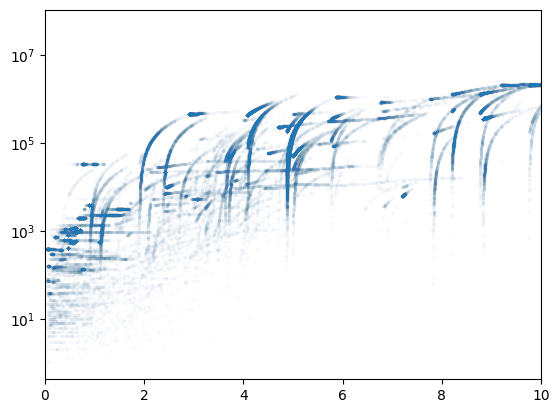

In [69]:
xx = [ee["maxdepth"] for ee in flood_pts]
yy = [ee["area"] for ee in flood_pts]
ax =plt.subplot(1,1,1)
ax.scatter(xx,yy, s=3, alpha=0.01)
plt.yscale('log')
ax.set_xlim(0, 10)
#ax.set_ylim(0,2e4)

In [70]:
selected_pts = [pt for pt in flood_pts if pt["maxdepth"] < maxdepth and pt["area"]<=maxarea]
print(f"{len(selected_pts)} / {len(flood_pts)}")

36189 / 1578801


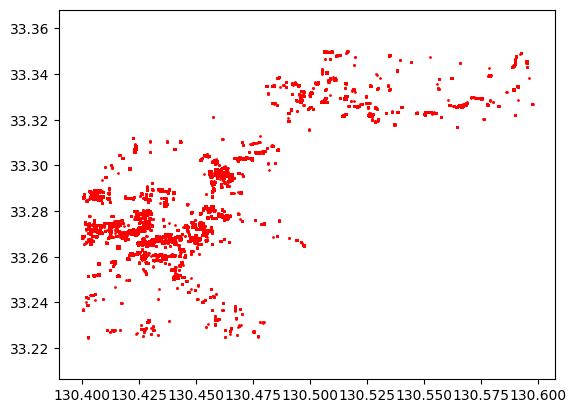

In [71]:
if True: # flg_display:
  xx = [pt["lon"] for pt in selected_pts]
  yy = [pt["lat"] for pt in selected_pts]
  ax = plt.subplot(111)
  ax.scatter(xx,yy,s=1,c="r")
  ax.axis("equal")

In [72]:
sorted_pts = sorted(selected_pts, key=lambda x:x["dem"], reverse=True)

In [73]:

floodmap_msk = np.zeros_like(vbi.data, dtype=float)
floodmap_dem = np.ones_like(vbi.data) * errordem
save_pts = []
cnt0 = 10000
cnt = cnt0
for pt in progressbar(sorted_pts):
  cx, cy = vbi.calc_floatIdxs(pt["lon"],pt["lat"])
  cx = int(cx)
  cy = int(cy)
  if pt["area"] > 0 and floodmap_msk[cy,cx] == 0: #and floodmap_dem[cy,cx] < pt["dem"]:
    #print(cx, cy, floodmap[cx,cy], ee["dem"])
    tmp_msk = vbi.generate_boundmap_exact(pt["lon"],pt["lat"], pt["dem"])
    tmp_dem = tmp_msk * pt["dem"] + (1-tmp_msk) * errordem
    #tmp_dem[np.where(tmp_msk == 0)] = errordem
    #tmp_depth = np.nanmax(tmp_dem - vbi.data)
    #if tmp_depth <= maxdepth:
    cnt = cnt  - 1
    tmp_id = tmp_msk * cnt
    #floodmap_msk[np.where(floodmap_msk)==0] = tmp_msk[np.where(floodmap_msk)==0] * cnt
    floodmap_msk = np.maximum(floodmap_msk, tmp_id)
    floodmap_dem = np.maximum(floodmap_dem, tmp_dem)
    save_pts.append(pt)
floodmap_dem = floodmap_dem[1:-1,1:-1]
floodmap_dem[np.where(floodmap_dem == errordem)] = np.nan
floodmap_msk = floodmap_msk[1:-1,1:-1]
floodmap_msk[np.where(floodmap_msk)==0] = np.nan
floodmap_msk = cnt0 - floodmap_msk
cnt = cnt0-cnt

100% (36189 of 36189) |##################| Elapsed Time: 0:02:15 Time:  0:02:15


In [74]:
print(cnt)
print(np.nanmin(floodmap_msk),np.nanmax(floodmap_msk))
print(floodmap_msk)
print(floodmap_dem)

255
1.0 10000.0
[[246. 246. 246. ... 246. 246. 246.]
 [246. 246. 246. ... 246. 246. 246.]
 [246. 246. 246. ... 246. 246. 246.]
 ...
 [246. 246. 246. ... 246. 246. 246.]
 [246. 246. 246. ... 246. 246. 246.]
 [246. 246. 246. ... 246. 246. 246.]]
[[2.90314878 2.90314878 2.90314878 ... 2.90314878 2.90314878 2.90314878]
 [2.90314878 2.90314878 2.90314878 ... 2.90314878 2.90314878 2.90314878]
 [2.90314878 2.90314878 2.90314878 ... 2.90314878 2.90314878 2.90314878]
 ...
 [2.90314878 2.90314878 2.90314878 ... 2.90314878 2.90314878 2.90314878]
 [2.90314878 2.90314878 2.90314878 ... 2.90314878 2.90314878 2.90314878]
 [2.90314878 2.90314878 2.90314878 ... 2.90314878 2.90314878 2.90314878]]


In [75]:
demmap = vbi.data[1:-1,1:-1]
depthmap = floodmap_dem - demmap
depthmap[np.where(depthmap < 0)] = np.nan
floodmap_dem[np.where(np.isnan(depthmap))] = np.nan
floodmap_msk[np.where(np.isnan(depthmap))] = np.nan

In [76]:
print(depthmap)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [77]:
print(floodmap_msk)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


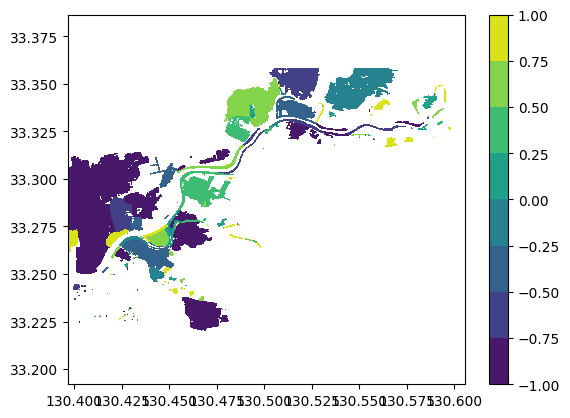

In [78]:
if True: #flg_display:
  ax =plt.subplot(1,1,1)
  img = ax.contourf(lons,lats, np.sin(floodmap_msk*0.1))#,levels=np.arange(1,cnt+10,10))
  ax.axis("equal")
  #plt.xlim([130.54, 130.59])
  #plt.ylim([33.31, 33.36])
  plt.colorbar(img)

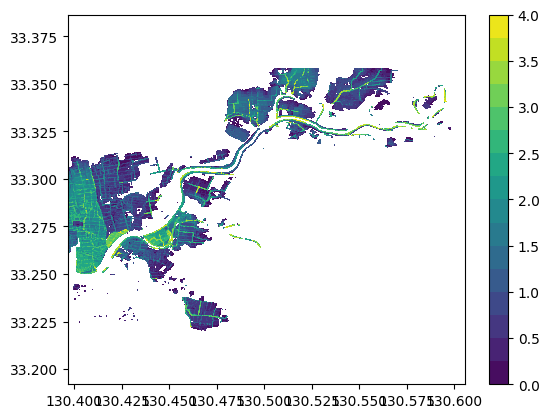

In [79]:
if True: #flg_display:
  ax =plt.subplot(1,1,1)
  img = ax.contourf(lons,lats, depthmap,levels=np.arange(0,maxdepth+0.1,0.25))
  ax.axis("equal")
  plt.colorbar(img)
  #ax.set_xlim(130.4,130.5)
  #ax.set_ylim(33.22,33.32)

In [80]:
if flg_display:
  xx = [pt["lon"] for pt in sorted_pts]
  yy = [pt["lat"] for pt in sorted_pts]
  ax =plt.subplot(1,1,1)
  img = ax.contourf(lons,lats, depthmap,levels=np.arange(0,maxdepth+0.1,0.25))
  plt.colorbar(img)
  ax.scatter(xx,yy, c="c", s=0.1)
  ax.axis("equal")
  ax.set_xlim(130.4,130.5)
  ax.set_ylim(33.22,33.32)

In [81]:
del img

In [82]:
print(floodmap_dem)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [83]:
print(len(save_pts))

255


In [84]:
np.savez(file_flooddem.format(int(maxdepth*100)), lons=lons, lats=lats, floodmap_dem=floodmap_dem)
np.savez(file_flooddepth.format(int(maxdepth*100)), lons=lons, lats=lats, floodmap_depth=depthmap)